[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

In this notebook, we are going to cover a technique called **Transfer Learning**, which generally refers to a process where a machine learning model is trained on one problem, and afterwards, it is reused in some way on a second (probably) related problem (Bengio, 2012). Specifically, in **deep learning**, this technique is used by training only some layers of the pre-trained network. Its promise is that the training will be more efficient and in the best of the cases the performance will be better compared to a model trained from scratch. 

Although the choice of an architecture is an important decision, other hyper-paramenters such as the **optimizer** method can play a critical role in deep learning. Basically, optimizers **modify the weights** of the network **given the gradients** and, maybe, additional information, depending on the type of the optimizer. Most optimizers are based on gradient descent, the approach of iteratively decreasing the loss function by following the gradient. Gradient descent can be as simple as subtracting the gradients from the weights, or can also be very sophisticated. The choice of optimizer can dramatically influence the performance of the model. 

In this notebook, we are going to compare (i) a simple optimizer but still powerful and widely used, which is named **Stochastic Gradient Descent (SGD)**, and (ii) a more recent one, which is used in many recent research papers, whose name is **Adaptive Moment Estimation (Adam)**. The difference is that  SGD subtracts the gradient multiplied by the same learning rate from the weights, while Adam computes adaptive learning rates for each parameter. Although theoretically more powerful, Adam introduces two new hyperparameters that complicate the hyperparameter tuning problem.

This notebook represents an extension over the previous Eden notebooks:
1. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-1.ipynb
2. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-2.ipynb
3. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-3.ipynb
4. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-4.ipynb
5. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-5.ipynb
6. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-6.ipynb
7. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-7.ipynb

#### Library Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import cv2
import os
import csv
import gc
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pathlib import Path

import tensorflow as tf 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import *
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.keras.applications.xception import preprocess_input
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

#### Auxiliar functions
Check the docstrings for more information.

In [2]:
# Function for plotting images.
def plot_sample(X):
    """
    Given the array of images <X>, it plots a random subsample of 25 images.

        Parameters:
            X (ndarray): The array with all the images.
    """
    # Plotting 9 sample images
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))

    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(X[random.randint(0, X.shape[0]-1)])

def read_data(path_list, im_size=(224,224)):
    """
    Given the list of paths where the images are stored <path_list>,
    and the size for image decimation <im_size>, it returns 2 Numpy Arrays
    with the images and labels; and a dictionary with the mapping between
    classes and folders. This will be used later for displaying the predicted
    labels.

        Parameters:
            path_list (List[String]): The list of paths to the images.
            im_size (Tuple): The height and width values.

        Returns:
            X (ndarray): Images
            y (ndarray): Labels
            tag2idx (dict): Map between labels and folders.
    """

    X = []
    y = []
    
    # Exctract the file-names of the datasets we read and create a label dictionary. 
    tag2idx = {tag.split(os.path.sep)[-1]:i for i, tag in enumerate(path_list)}
    
    for path in path_list:
        for im_file in tqdm(glob(path + '*/*')): # Read all files in path
            try:
                # os.path.separator is OS agnostic (either '/' or '\'),[-2] to grab folder name.
                label = im_file.split(os.path.sep)[-2] 
                im = cv2.imread(im_file, cv2.IMREAD_COLOR) 
                # By default OpenCV read with BGR format, return back to RGB.
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                # Resize to appropriate dimensions.You can try different interpolation methods.
                #im = quantize_image(im)
                im = cv2.resize(im, im_size,interpolation=cv2.INTER_AREA)
                X.append(im)
                y.append(tag2idx[label])# Append the label name to y 
            except Exception as e:
                # In case annotations or metadata are found
                print("Not a picture")
    
    X = np.array(X) # Convert list to numpy array.
    y = np.eye(len(np.unique(y)))[y].astype(np.uint8)
    
    return X, y

# Callbacks are used for saving the best weights and
# early stopping.
def get_callbacks(weights_file, patience):
    """
    Callbacks are used for saving the best weights and early stopping.
    Given some configuration parameters, it creates the callbacks that
    will be used by Keras after each epoch.

        Parameters:
            weights_file (String): File name for saving the best model weights.
            patience (Integer): Number of epochs without improvement to wait.

        Returns:
            callbacks (List[Callbacks]): Configured callbacks ready to use.
    """
    return [
        # Only save the weights that correspond to the maximum validation accuracy.    
        ModelCheckpoint(filepath= weights_file,
                        monitor="val_accuracy",
                        mode="max",
                        save_best_only=True, 
                        save_weights_only=True),
        # If val_loss doesn't improve for a number of epochs set with 'patience' var 
        # training will stop to avoid overfitting.     
        EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience = patience,
                      verbose=1)
        ]
        

#Plot learning curves for both validation accuracy & loss,
#training accuracy & loss
def plot_performances(performances):
    '''
    Given the list of performances (validation accuracies) and method-name <performances>, 
    it plots how the validation accuracy progressed during the training/validation process.

        Parameters:
            performances (List[Tuple]): The list of method-performance tuples.
    '''
    plt.figure(figsize=(14, 8))
    plt.title("Validation Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Validation Accuracy")
    for performance in performances:
        plt.plot(range(1,len(performance[1])+1), performance[1], 
                 label=performance[0])
    plt.ylim((0.25,1.05))
    plt.xticks(np.arange(1, NUM_EPOCHS+1, 1.0))
    plt.legend()
    plt.show()

#### Experimental Constants

In [3]:
INPUT_SHAPE = (224, 224, 3)
IM_SIZE = (224, 224)
NUM_EPOCHS = 30
BATCH_SIZE = 4
TEST_SPLIT = 0.2
VAL_SPLIT = 0.2
RANDOM_STATE = 2021
WEIGHTS_FILE = "weights.h5"# File that stores updated weights
# Datasets' paths we want to work on.
PATH_LIST = ["eden_library_datasets/Orange tree-060521-K deficiency-zz-V1-20210721140920",
             "eden_library_datasets/Orange tree-060521-Mg deficiency-zz-V1-20210721140926"]

tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

#### Loading images and Data Loaders

In [4]:
i=0
for path in PATH_LIST:
    #Define paths in an OS agnostic way.
    PATH_LIST[i] = str(Path(Path.cwd()).parents[0].joinpath(path)) 
    i+=1
X, y = read_data(PATH_LIST, IM_SIZE)

100%|██████████| 45/45 [00:04<00:00,  9.22it/s]


#### Displaying some sample images

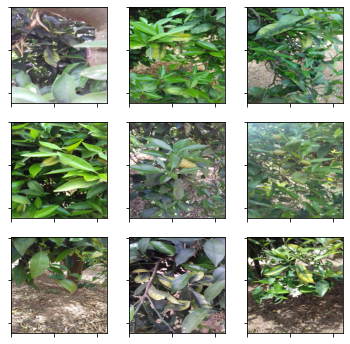

In [5]:
plot_sample(X)

### Data Augmentation + Visualization

In [6]:
img_augmentation = Sequential([
    preprocessing.RandomRotation(factor=0.15),                     
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
    preprocessing.RandomFlip(),
    preprocessing.RandomContrast(factor=0.1),
  ],
  name="img_augmentation"
)

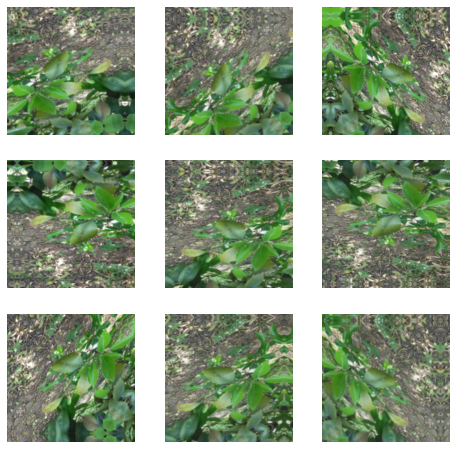

In [7]:
IMAGE_IX = 10
image = tf.expand_dims(X[IMAGE_IX], axis=0)

plt.figure(figsize=(8, 8))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  aug_img = img_augmentation(image)
  plt.imshow(aug_img[0].numpy().astype("uint8"))
  plt.axis("off")
plt.show()  

In [8]:
def get_architecture(y, mobilenet_size, optimizer, learning_rate):
    """
    Given the parameters, it returns a compiled architecture (MobileNetV3)
    ready for training.
    """
    inputs = layers.Input(shape=INPUT_SHAPE)
    input_aug = img_augmentation(inputs)
    input_norm = layers.Lambda(preprocess_input)(input_aug) # placeholder in this case

    if mobilenet_size == "small":
        feature_extractor = MobileNetV3Small(
            weights="imagenet",
            include_top=False,
            input_tensor=input_norm)
    elif mobilenet_size == "large":
        feature_extractor = MobileNetV3Large(
            weights="imagenet",
            include_top=False,
            input_tensor=input_norm)

    # Create new model on top.
    feataures = layers.GlobalAveragePooling2D(name="pool")(feature_extractor.output) # Flattening layer.  
    fully = layers.Dense(units=64, activation="relu")(feataures) # Add a fully connected layer.
    # Create a Classifier with shape=number_of_training_classes.
    fully = layers.Dropout(0.3)(fully) # Regularize with dropout.
    out = layers.Dense(units=y.shape[1], 
                  activation="softmax")(fully)
    # This is the final model.            
    model = Model(inputs, out)

    # Defining a base learning rate for optimizer.
    base_learning_rate = learning_rate
    if optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate)
    elif optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(lr=base_learning_rate)
    else:
        print("[ERROR] Unknown optimizer")
    
    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    #model.summary()
    return model

#### Training / Fine-Tuning Models

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=TEST_SPLIT,
                                                    shuffle = True,
                                                    stratify = y,
                                                    random_state = RANDOM_STATE)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=VAL_SPLIT, 
                                                  shuffle = True,
                                                  stratify = y_train,
                                                  random_state = RANDOM_STATE)

In [10]:
%%time
model = get_architecture(y, 
                         mobilenet_size="small",
                         optimizer="adam",
                         learning_rate=1e-2)

history_v3Small_adam_lr2 = model.fit(X_train, # train data
                                     y_train, # labels
                                     batch_size=BATCH_SIZE,
                                     epochs=NUM_EPOCHS,
                                     validation_data=(X_val, y_val),
                                     callbacks=get_callbacks(WEIGHTS_FILE, 
                                                             NUM_EPOCHS//2))

Epoch 1/30
13/13 [==============================] - 8s 123ms/step - loss: 4.8325 - accuracy: 0.4490 - val_loss: 992.1439 - val_accuracy: 0.6154
Epoch 2/30
13/13 [==============================] - 0s 37ms/step - loss: 0.7013 - accuracy: 0.7551 - val_loss: 1915.9366 - val_accuracy: 0.6154
Epoch 3/30
13/13 [==============================] - 0s 34ms/step - loss: 0.6486 - accuracy: 0.7347 - val_loss: 159503.6094 - val_accuracy: 0.3846
Epoch 4/30
13/13 [==============================] - 0s 36ms/step - loss: 0.7734 - accuracy: 0.5918 - val_loss: 23689.2363 - val_accuracy: 0.6154
Epoch 5/30
13/13 [==============================] - 0s 32ms/step - loss: 1.2911 - accuracy: 0.4898 - val_loss: 59493.8047 - val_accuracy: 0.3846
Epoch 6/30
13/13 [==============================] - 0s 36ms/step - loss: 0.4381 - accuracy: 0.7347 - val_loss: 454340.3750 - val_accuracy: 0.3846
Epoch 7/30
13/13 [==============================] - 0s 32ms/step - loss: 1.2017 - accuracy: 0.6327 - val_loss: 45697.6445 - val_ac

In [11]:
model.load_weights(WEIGHTS_FILE)
final_accuracy_adam_lr2 = model.evaluate(X_test, y_test, 
                                batch_size=1,
                                verbose=0)[1]
print("*"*50)
print(f"Final MobileNetV3-Small-Adam-LR=0.01 Accuracy: {final_accuracy_adam_lr2}")
print("*"*50)
print()

**************************************************
Final MobileNetV3-Small-Adam-LR=0.01 Accuracy: 0.5625
**************************************************



In [ ]:
model = get_architecture(y, 
                         mobilenet_size="small",
                         optimizer="adam",
                         learning_rate=1e-4)

history_v3Small_adam_lr4 = model.fit(X_train, # train data
                                     y_train, # labels
                                     batch_size=BATCH_SIZE,
                                     epochs=NUM_EPOCHS,
                                     validation_data=(X_val, y_val),
                                     callbacks=get_callbacks(WEIGHTS_FILE, 
                                                             NUM_EPOCHS//2))

Epoch 1/30
13/13 [==============================] - 5s 93ms/step - loss: 1.0651 - accuracy: 0.3469 - val_loss: 0.7092 - val_accuracy: 0.6154
Epoch 2/30
13/13 [==============================] - 0s 32ms/step - loss: 0.6028 - accuracy: 0.7143 - val_loss: 0.6906 - val_accuracy: 0.5385
Epoch 3/30
13/13 [==============================] - 0s 34ms/step - loss: 0.4854 - accuracy: 0.7959 - val_loss: 0.6951 - val_accuracy: 0.6154
Epoch 4/30
13/13 [==============================] - 0s 33ms/step - loss: 0.5316 - accuracy: 0.7143 - val_loss: 0.6442 - val_accuracy: 0.6154
Epoch 5/30
13/13 [==============================] - 0s 34ms/step - loss: 0.5138 - accuracy: 0.6939 - val_loss: 0.6957 - val_accuracy: 0.6154
Epoch 6/30
13/13 [==============================] - 0s 33ms/step - loss: 0.4393 - accuracy: 0.8163 - val_loss: 0.6324 - val_accuracy: 0.6154
Epoch 7/30
13/13 [==============================] - 0s 37ms/step - loss: 0.4273 - accuracy: 0.8571 - val_loss: 0.6179 - val_accuracy: 0.6154
Epoch 8/30
13

In [ ]:
model.load_weights(WEIGHTS_FILE)
final_accuracy_adam_lr4 = model.evaluate(X_test, y_test, 
                                         batch_size=1,
                                         verbose=0)[1]
print("*"*50)
print(f"Final MobileNetV3-Small-Adam-LR=0.0001 Accuracy: {final_accuracy_adam_lr4}")
print("*"*50)
print()

In [ ]:
%%time
model = get_architecture(y, 
                         mobilenet_size="large",
                         optimizer="sgd",
                         learning_rate=1e-2)

history_v3Small_sgd_lr2 = model.fit(X_train, # train data
                                    y_train, # labels
                                    batch_size=BATCH_SIZE,
                                    epochs=NUM_EPOCHS,
                                    validation_data=(X_val, y_val),
                                    callbacks=get_callbacks(WEIGHTS_FILE, 
                                                            NUM_EPOCHS//2))

In [ ]:
model.load_weights(WEIGHTS_FILE)
final_accuracy_sgd_lr2 = model.evaluate(X_test, y_test, 
                                batch_size=1,
                                verbose=0)[1]
print("*"*50)
print(f"Final MobileNetV3-Small-SGD-LR=0.01 Accuracy: {final_accuracy_sgd_lr2}")
print("*"*50)
print()

In [ ]:
model = get_architecture(y, 
                         mobilenet_size="large",
                         optimizer="sgd",
                         learning_rate=1e-4)

history_v3Small_sgd_lr4 = model.fit(X_train, # train data
                                     y_train, # labels
                                     batch_size=BATCH_SIZE,
                                     epochs=NUM_EPOCHS,
                                     validation_data=(X_val, y_val),
                                     callbacks=get_callbacks(WEIGHTS_FILE, 
                                                             NUM_EPOCHS//2))

In [ ]:
model.load_weights(WEIGHTS_FILE)
final_accuracy_sgd_lr4 = model.evaluate(X_test, y_test, 
                                batch_size=1,
                                verbose=0)[1]
print("*"*50)
print(f"Final MobileNetV3-Small-SGD-LR=0.0001 Accuracy: {final_accuracy_sgd_lr4}")
print("*"*50)
print()

#### Plotting Performances

In [ ]:
# Preparing performances for being plotted
performances = [(f"Adam-LR=0.01 ({round(final_accuracy_adam_lr2, 3)})", 
                  history_v3Small_adam_lr2.history["val_accuracy"]),
                (f"Adam-LR=0.0001 ({round(final_accuracy_adam_lr4, 3)})", 
                  history_v3Small_adam_lr4.history["val_accuracy"]), 
                (f"SGD-LR=0.01 ({round(final_accuracy_sgd_lr2, 3)})", 
                  history_v3Small_sgd_lr2.history["val_accuracy"]), 
                (f"SGD-LR=0.0001 ({round(final_accuracy_sgd_lr4, 3)})", 
                  history_v3Small_sgd_lr4.history["val_accuracy"])]

In [ ]:
plot_performances(performances)

## Conclusions
The correct selection of optimizer and learning rate makes a real difference in performance.

## Possible Extensions
1. Use a different pre-trained network (for instance, MobileNetV3Large).
2. Try a different training approach where pre-trained weights are not loaded.
3. Try different epochs and batch sizes.

## Bibliography
Bengio, Y., 2012. Deep Learning of Representations for Unsupervised and Transfer Learning. In: Journal of Machine Learning Research; 17–37.

Wang, G., Sun, Y., Wang, J., (2017). Automatic Image-Based Plant Disease Severity Estimation Using Deep Learning. Computational Intelligence and Neuroscience; 2017:8.

Mehdipour-Ghazi, M., Yanikoglu, B.A., & Aptoula, E. (2017). Plant identification using deep neural networks via optimization of transfer learning parameters. Neurocomputing, 235, 228-235.

Suh, H.K., IJsselmuiden, J., Hofstee, J.W., van Henten, E.J., (2018). Transfer learning for the classification of sugar beet and volunteer potato under field conditions. Biosystems Engineering; 174:50–65.

Kounalakis T., Triantafyllidis G. A., Nalpantidis L., (2019). Deep learning-based visual recognition of rumex for robotic precision farming. Computers and Electronics in Agriculture.

Too, E.C., Yujian, L., Njuki, S., & Ying-chun, L. (2019). A comparative study of fine-tuning deep learning models for plant disease identification. Comput. Electron. Agric., 161, 272-279.

Espejo-Garcia, B., Mylonas, N., Athanasakos, L., & Fountas, S., (2020). Improving
Weeds Identification with a Repository of Agricultural Pre-trained Deep Neural
Networks. Computers and Electronics in Agriculture; 175 (August).

Sandler, M., Howard, A.G., Zhu, M., Zhmoginov, A., & Chen, L. (2018). MobileNetV2: Inverted Residuals and Linear Bottlenecks. 2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition, 4510-4520.

Howard, A.G., Sandler, M., Chu, G., Chen, L., Chen, B., Tan, M., Wang, W., Zhu, Y., Pang, R., Vasudevan, V., Le, Q.V., & Adam, H. (2019). Searching for MobileNetV3. 2019 IEEE/CVF International Conference on Computer Vision (ICCV), 1314-1324.

https://medium.com/geekculture/a-2021-guide-to-improving-cnns-optimizers-adam-vs-sgd-495848ac6008

https://arxiv.org/abs/1609.04747